In [8]:
import math

import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from typing import Type, Dict

from ds.wesad.datasets import SubjectDataset, subjects_data

In [9]:
def _get_rate_from_str(s):
    return float(s.split("(")[-1].split(")", maxsplit=1)[0])

## Common

In [18]:
prefix = "NetUpDownCoder3"
reduce = {"": "Conv", "AP": "AvgPool", "MP": "MaxPool"}

In [19]:
rates = {key: {} for key in reduce.values()}
for net in sorted(Path().glob(f"{prefix}*")):
    logs = net / "logs" / "train.log"
    reduce_, signal_len, _ = net.stem.replace(prefix, "").split("_", 2)
    signal_len = int(signal_len)
    content = logs.read_text().strip().splitlines()[-1]
    rate = _get_rate_from_str(content)
    rates[reduce[reduce_]].update({signal_len: rate})

In [20]:
derivative_rates = {key: {} for key in reduce.values()}
for net in sorted(Path("derivative").glob(f"NetUpDownCoder3*")):
    logs = net / "logs" / "train.log"
    reduce_, signal_len, _ = net.stem.replace(prefix, "").split("_", 2)
    signal_len = int(signal_len)
    content = logs.read_text().strip().splitlines()[-1]
    rate = _get_rate_from_str(content)
    derivative_rates[reduce[reduce_]].update({signal_len: rate})

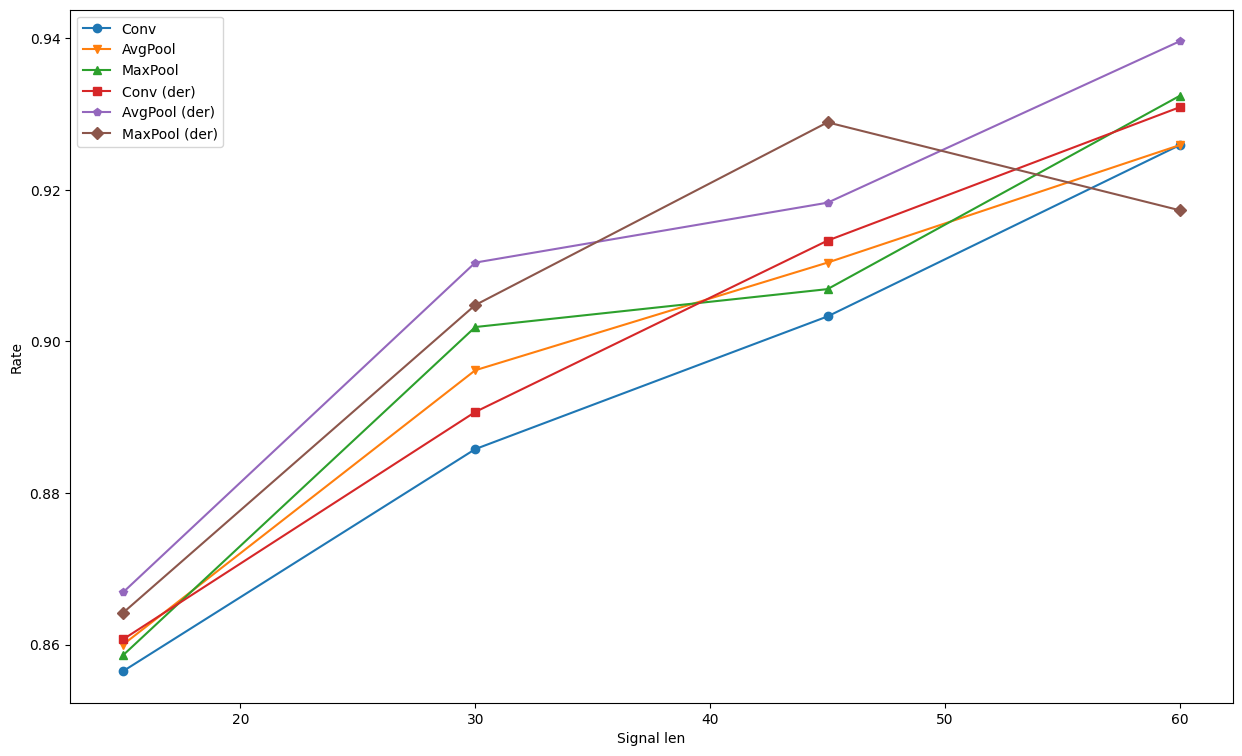

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
markers = ["o", "v", "^", "s", "p", "D"]
plt_data = dict(
    [
        *rates.items(),
        *map(lambda x: (f"{x[0]} (der)", x[1]), derivative_rates.items()),
    ]
)
for (r_type, data), marker in zip(plt_data.items(), markers):
    ax.plot(data.keys(), data.values(), f"-{marker}", label=r_type)
ax.set_xlabel("Signal len")
ax.set_ylabel("Rate")
ax.legend()
plt.show()

### Derivative

In [7]:
derivative_rates = {}
for net in sorted(Path("derivative").glob(f"NetUpDownCoder3*")):
    logs = net / "logs" / "train.log"
    signal_len = int(net.stem.split("_", 2)[1])
    content = logs.read_text().strip().splitlines()[-1]
    rate = _get_rate_from_str(content)
    derivative_rates[signal_len] = rate

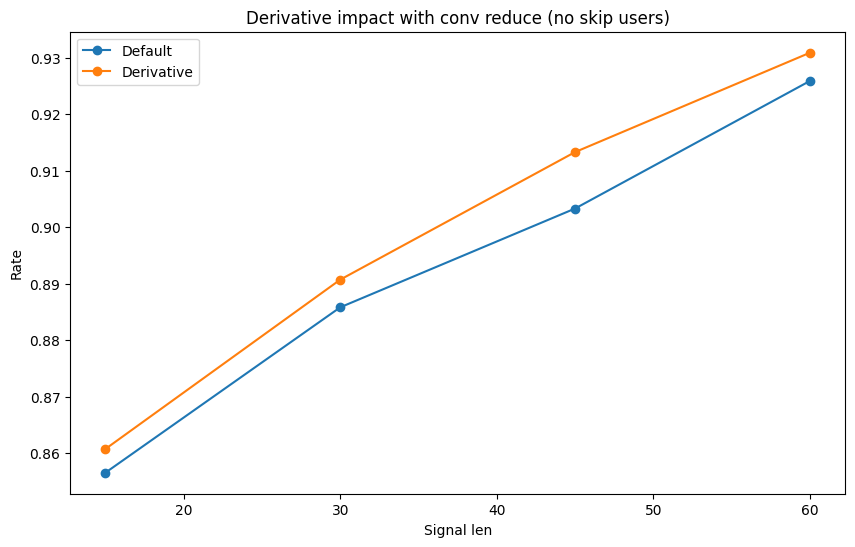

In [8]:
non_derivative_rates = rates.get("Conv")
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(
    non_derivative_rates.keys(),
    non_derivative_rates.values(),
    "-o",
    label="Default",
)
ax.plot(
    derivative_rates.keys(),
    derivative_rates.values(),
    "-o",
    label="Derivative",
)
ax.set_xlabel("Signal len")
ax.set_ylabel("Rate")
ax.legend()
ax.set_title("Derivative impact with conv reduce (no skip users)")
plt.show()

## Skip user

In [9]:
signal_len_to_rate_user = {}
for net in sorted(Path("skip_users").glob("NetUpDownCoder3_*_ASGD_lr_1e-06")):
    logs = net / "logs"
    signal_len = int(net.name.split("_", 2)[1])
    if signal_len == 3:
        signal_len = 30
    signal_info = {}
    for log in logs.iterdir():
        skip_subj = int(log.name.split("_")[-1].split(".")[0])
        content = log.read_text().strip().splitlines()
        best_common = _get_rate_from_str(content[-3])
        best_single = _get_rate_from_str(content[-1])
        signal_info[skip_subj] = {
            "common": best_common,
            "single": best_single,
        }
    signal_len_to_rate_user[signal_len] = signal_info

In [10]:
signal_len_to_rate_user_with_derivative = {}
for net in sorted(
    Path("derivative/skip_users").glob("NetUpDownCoder3_*_ASGD_lr_1e-06")
):
    logs = net / "logs"
    signal_len = int(net.name.split("_", 2)[1])
    if signal_len == 3:
        signal_len = 30
    signal_info = {}
    for log in logs.iterdir():
        skip_subj = int(log.name.split("_")[-1].split(".")[0])
        content = log.read_text().strip().splitlines()
        best_common = _get_rate_from_str(content[-3])
        best_single = _get_rate_from_str(content[-1])
        signal_info[skip_subj] = {
            "common": best_common,
            "single": best_single,
        }
    signal_len_to_rate_user_with_derivative[signal_len] = signal_info

In [11]:
merged_len_to_rate_data = {
    type: {
        subj: {
            s_len: s_data.get(subj).get(type)
            for s_len, s_data in signal_len_to_rate_user.items()
        }
        for subj in signal_len_to_rate_user.get(15)
    }
    for type in signal_len_to_rate_user.get(15).get(2)
}

In [12]:
merged_len_to_rate_with_derivative_data = {
    type: {
        subj: {
            s_len: s_data.get(subj).get(type)
            for s_len, s_data in signal_len_to_rate_user_with_derivative.items()
        }
        for subj in signal_len_to_rate_user_with_derivative.get(15)
    }
    for type in signal_len_to_rate_user_with_derivative.get(15).get(2)
}

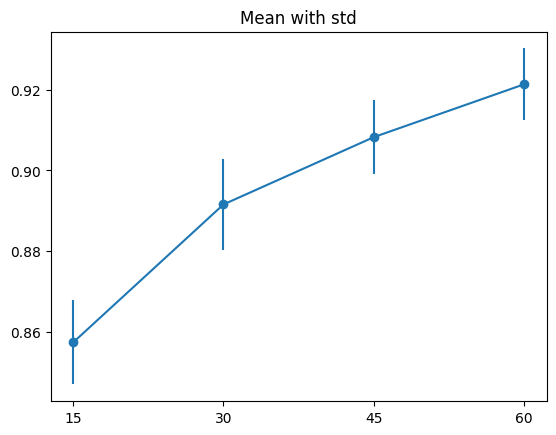

In [13]:
mean = []
std = []
for _, data in sorted(signal_len_to_rate_user.items()):
    d = list(map(lambda x: x.get("common"), data.values()))
    mean.append(np.mean(d))
    std.append(np.std(d))
plt.errorbar(sorted(signal_len_to_rate_user.keys()), mean, std, fmt="-o")
plt.xticks(sorted(signal_len_to_rate_user.keys()))
plt.title("Mean with std")
pass

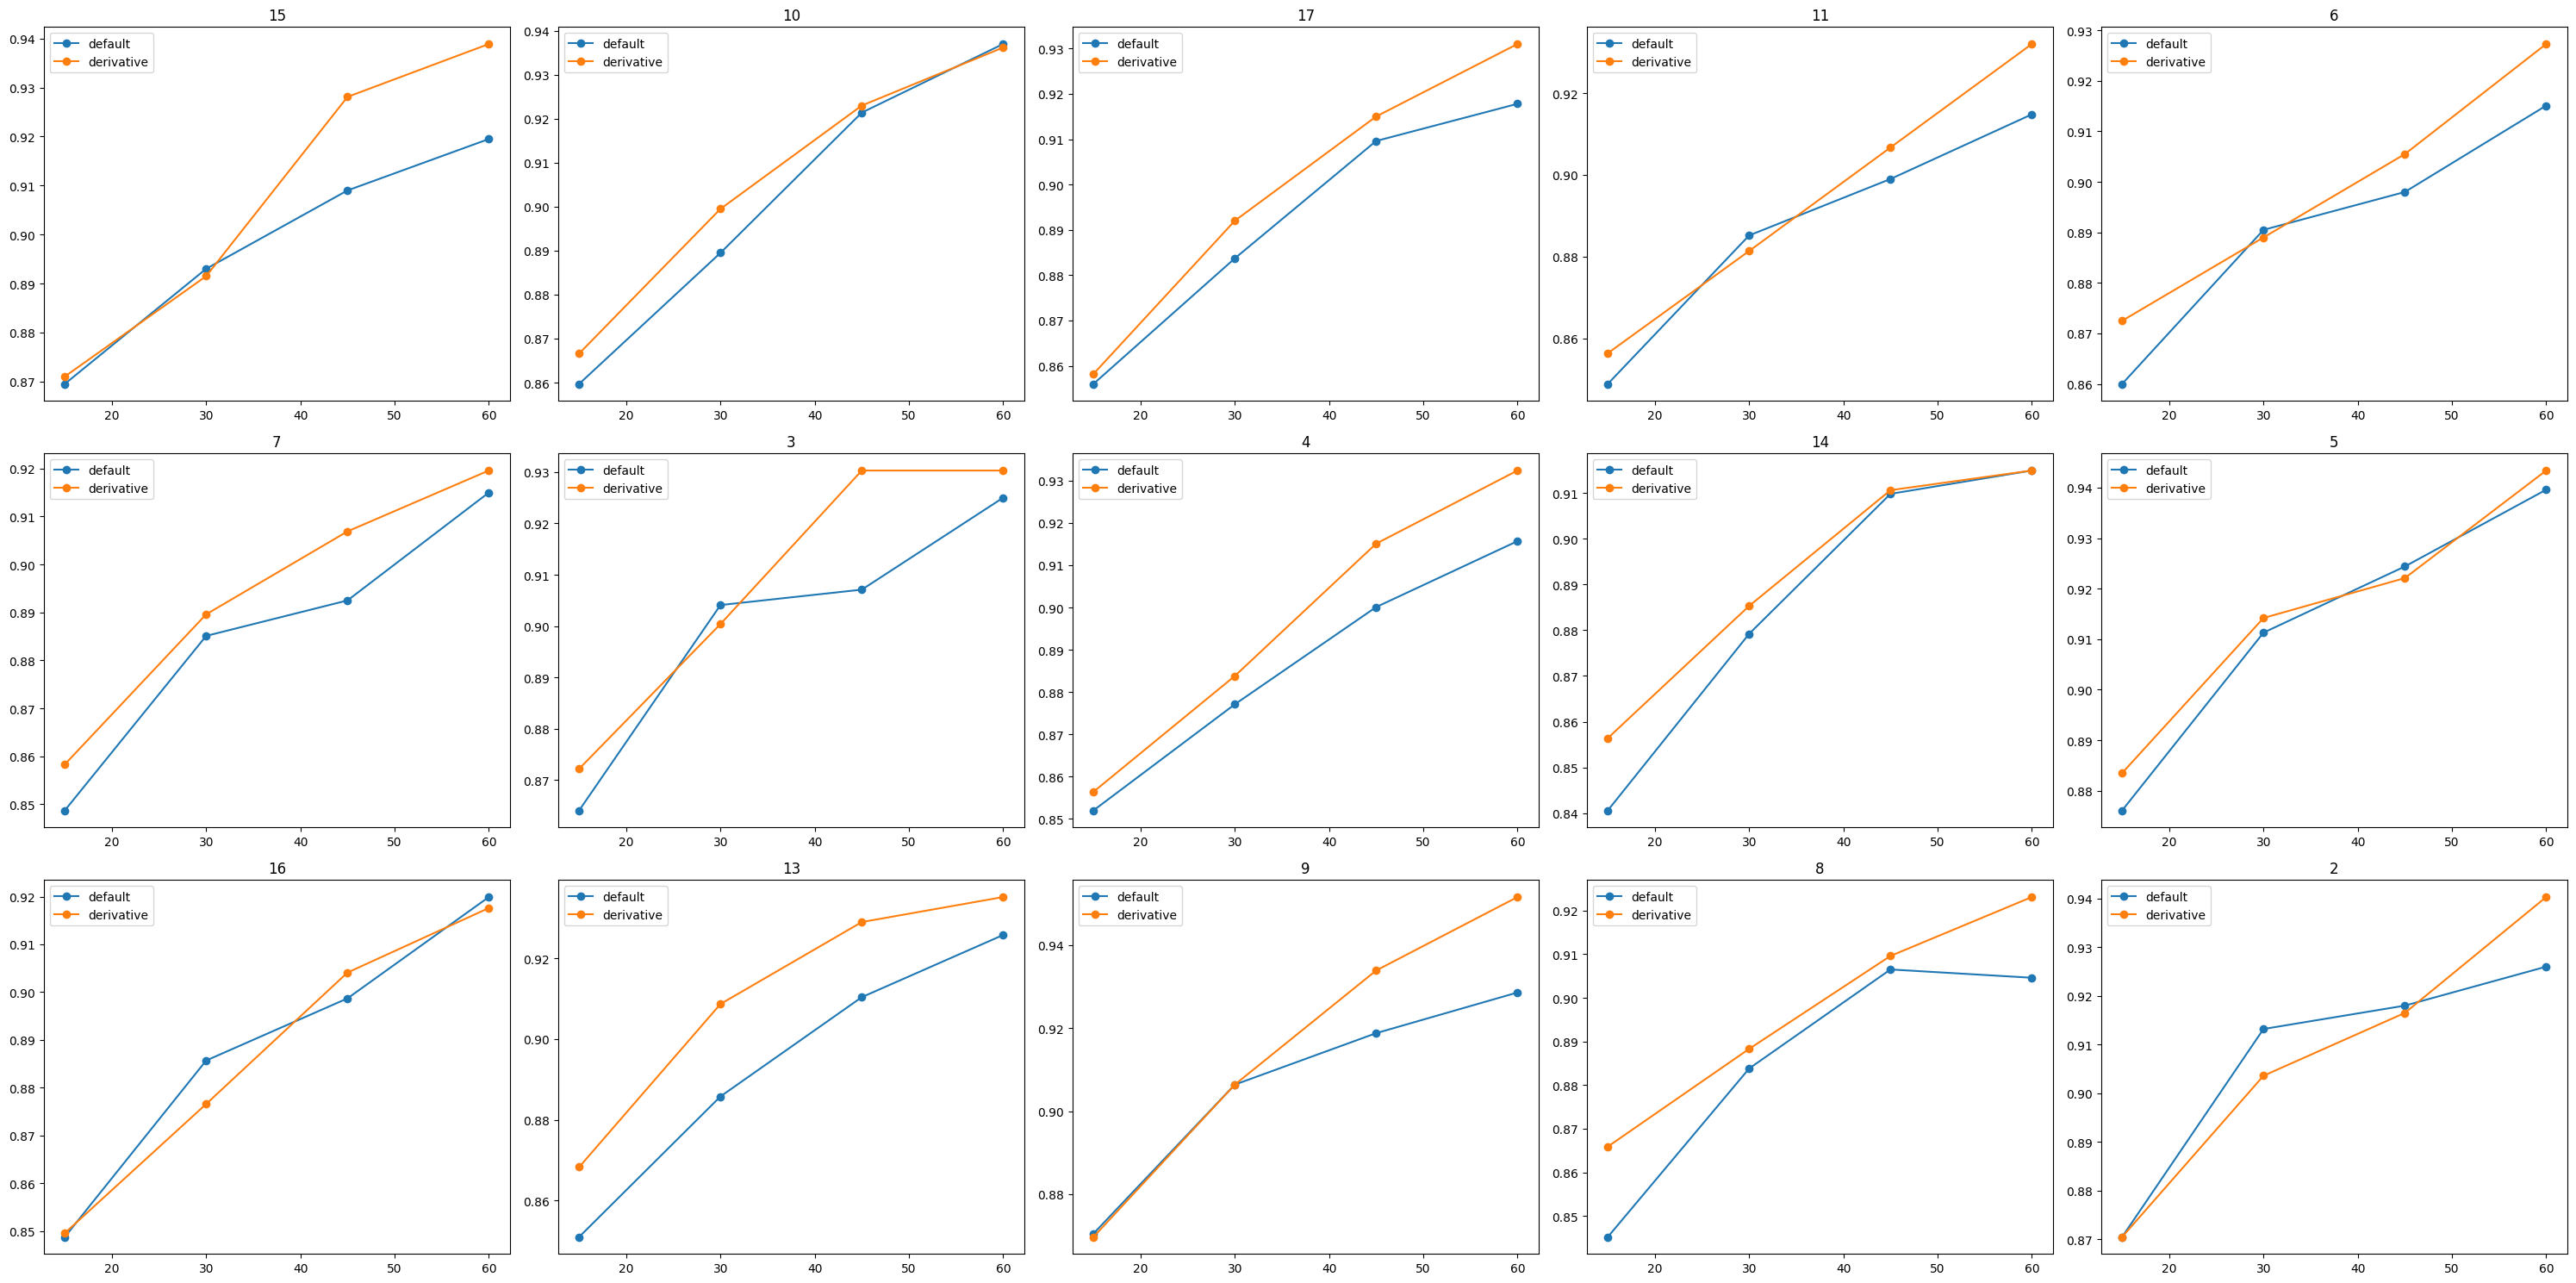

In [14]:
plt_per_line = 5
fig, ax = plt.subplots(
    math.ceil(merged_len_to_rate_data.get("common").__len__() / plt_per_line),
    plt_per_line,
    figsize=(30, 15),
)
for i, subj_id in enumerate(merged_len_to_rate_data.get("common")):
    s_data = merged_len_to_rate_data.get("common").get(subj_id)
    s_data_der = merged_len_to_rate_with_derivative_data.get("common").get(
        subj_id
    )
    ax[i // plt_per_line, i % plt_per_line].plot(
        s_data.keys(), s_data.values(), "-o", label="default"
    )
    ax[i // plt_per_line, i % plt_per_line].plot(
        s_data_der.keys(), s_data_der.values(), "-o", label="derivative"
    )
    ax[i // plt_per_line, i % plt_per_line].set_title(str(subj_id))
    ax[i // plt_per_line, i % plt_per_line].legend()
plt.tight_layout()

## Derivative and reduce

In [2]:
reduce_with_derivative = {}
for p in Path("derivative").glob("*60_ASGD_lr_1e-06"):
    logs = p / "logs" / "train.log"
    reduce_, signal_len, _ = p.stem.replace(prefix, "").split("_", 2)
    signal_len = int(signal_len)
    content = logs.read_text().strip().splitlines()[-1]
    rate = _get_rate_from_str(content)
    reduce_with_derivative[reduce[reduce_]] = rate

NameError: name 'prefix' is not defined

In [ ]:
reduce_without_derivative = {}
for p in Path().glob("*60_ASGD_lr_1e-06"):
    logs = p / "logs" / "train.log"
    reduce_, signal_len, _ = p.stem.replace(prefix, "").split("_", 2)
    signal_len = int(signal_len)
    content = logs.read_text().strip().splitlines()[-1]
    rate = _get_rate_from_str(content)
    reduce_without_derivative[reduce[reduce_]] = rate

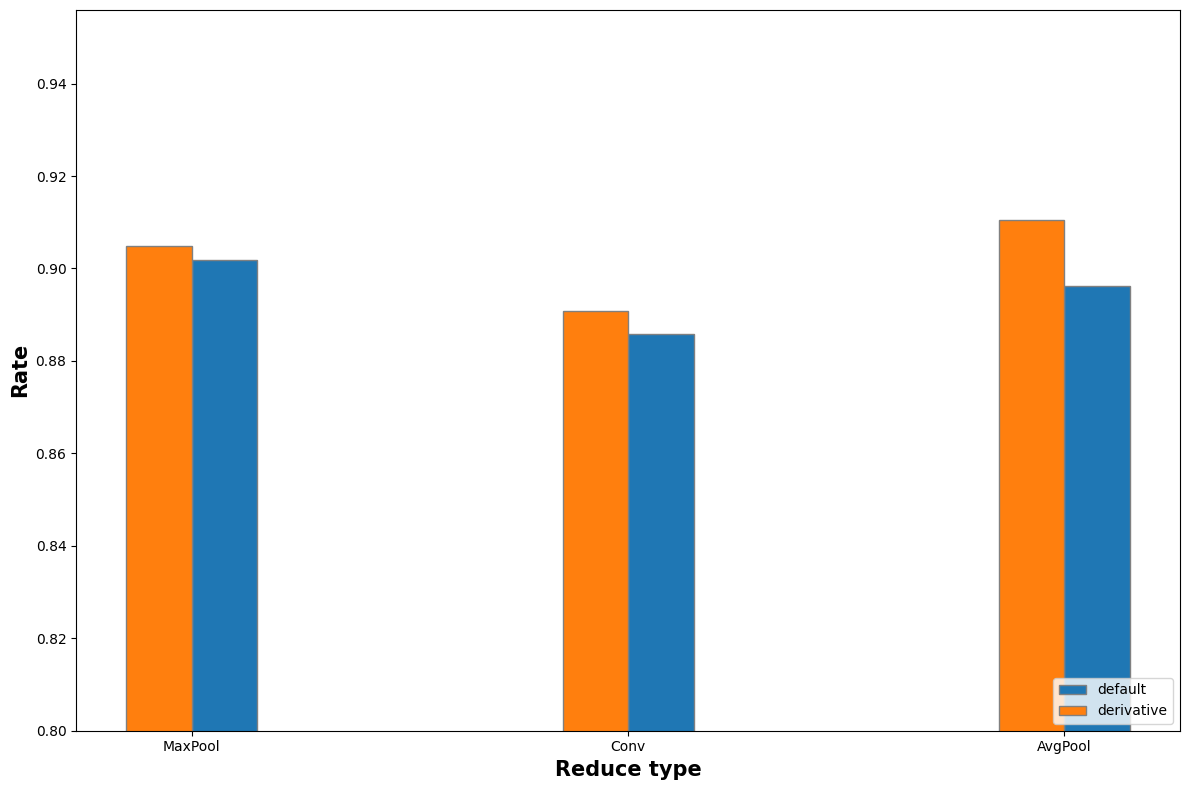

In [17]:
barWidth = 0.15
fig = plt.subplots(figsize=(12, 8))

pts = np.arange(len(reduce_with_derivative))
br1 = pts - barWidth / 2
br2 = pts + barWidth / 2

plt.bar(
    br2,
    reduce_without_derivative.values(),
    width=barWidth,
    edgecolor="grey",
    label="default",
)
plt.bar(
    br1,
    reduce_with_derivative.values(),
    width=barWidth,
    edgecolor="grey",
    label="derivative",
)

plt.xlabel("Reduce type", fontweight="bold", fontsize=15)
plt.ylabel("Rate", fontweight="bold", fontsize=15)
plt.xticks(pts, reduce_with_derivative.keys())
plt.ylim(bottom=0.8)
plt.legend(loc="lower right")
plt.tight_layout()

# New models classes

In [10]:
prefix = "NetUpDownCoder4"
reduce = {"Conv": "Conv", "Avg": "AvgPool", "Max": "MaxPool"}

In [11]:
rates = {key: {} for key in reduce.values()}
for net in sorted(Path().glob(f"{prefix}*")):
    logs = net / "logs" / "train.log"
    n_type = net.stem.replace(prefix, "").split("_", 1)[0]
    reduce_ = "".join(filter(str.isalpha, n_type))
    signal_len = int(n_type[len(reduce_) :])
    content = logs.read_text().strip().splitlines()[-1]
    rate = _get_rate_from_str(content)
    rates[reduce[reduce_]].update({signal_len: rate})

In [12]:
derivative_rates = {key: {} for key in reduce.values()}
for net in sorted(Path("derivative").glob(f"{prefix}*")):
    logs = net / "logs" / "train.log"
    if not logs.is_file():
        print(f"fail with {net}")
        continue
    n_type = net.stem.replace(prefix, "").split("_", 1)[0]
    reduce_ = "".join(filter(str.isalpha, n_type))
    signal_len = int(n_type[len(reduce_) :])
    content = logs.read_text().strip()
    if not content:
        continue
    content = content.splitlines()[-1]
    rate = _get_rate_from_str(content)
    derivative_rates[reduce[reduce_]].update({signal_len: rate})

In [13]:
plt_data = dict(
    [
        *rates.items(),
        *map(lambda x: (f"{x[0]} (der)", x[1]), derivative_rates.items()),
    ]
)
plt_data = {
    a_k: {k: round(v * 100, 2) for k, v in a_v.items()}
    for a_k, a_v in plt_data.items()
}

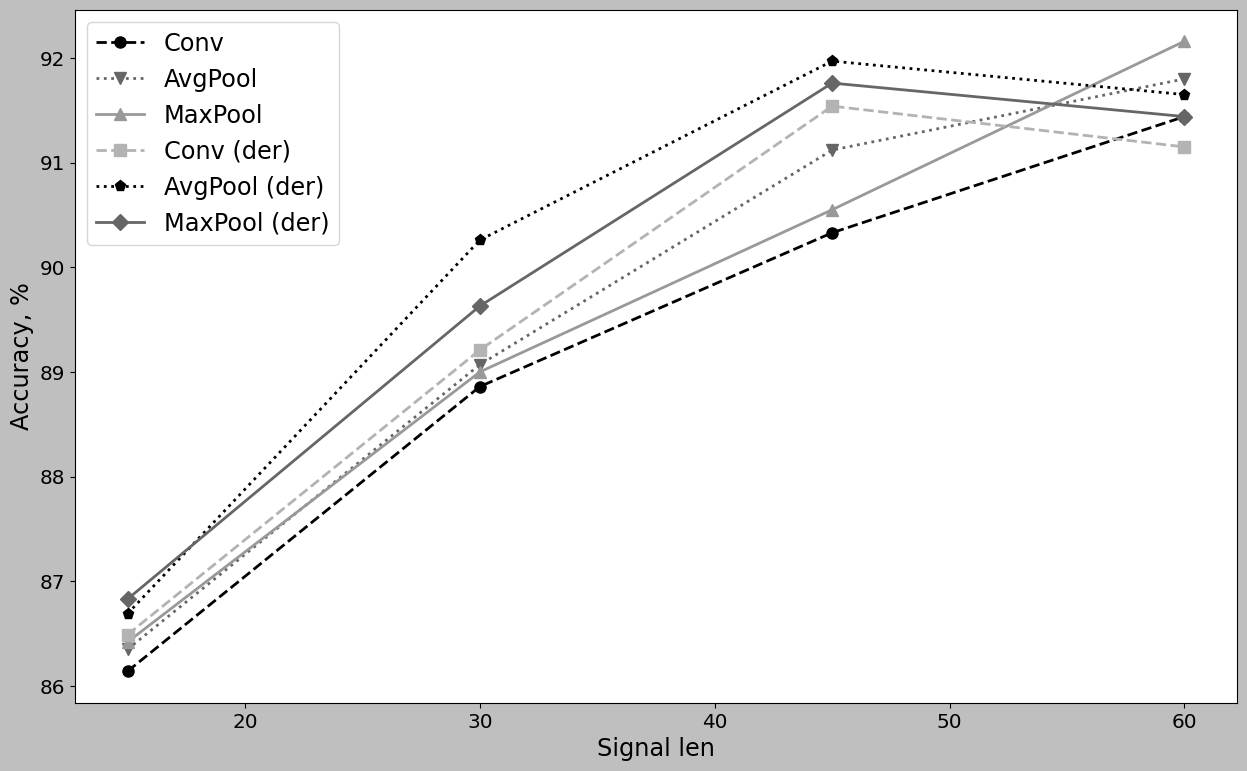

In [19]:
plt.style.use("grayscale")
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

ax.tick_params(axis='both', which='major', labelsize="x-large")
ax.tick_params(axis='both', which='minor', labelsize="x-large")

markers = ["o", "v", "^", "s", "p", "D"]
linestyles = ["--", ":", "-"] * 2

for (r_type, data), marker, linestyle in zip(plt_data.items(), markers, linestyles):
    ax.plot(
        data.keys(),
        data.values(),
        marker=marker,
        linestyle=linestyle,
        label=r_type,
        linewidth=2,
        markersize=8,
    )
ax.set_xlabel("Signal len", fontsize="xx-large")
ax.set_ylabel("Accuracy, %", fontsize="xx-large")
ax.legend(fontsize="xx-large")

plt.savefig("/home/dmo/Documents/human_func_state/human_func_state/assets/compare_modifications_depends_on_signal_len_gs.png")
plt.show()

### Table

In [10]:
delta_der = {
    reduce_type: {
        signal_len: round(acc - rates.get(reduce_type,{}).get(signal_len, 0), 4)
        for signal_len, acc in reduce_data.items()
    } for reduce_type, reduce_data in derivative_rates.items()
}

{'Conv': {15: 0.0035, 30: 0.0035, 45: 0.0121, 60: -0.0029},
 'AvgPool': {15: 0.0034, 30: 0.0119, 45: 0.0085, 60: -0.0015},
 'MaxPool': {15: 0.0041, 30: 0.0063, 45: 0.0121, 60: -0.0072}}